CNN - TRAFFIC SIGNS

This project aims to classify traffic signs using a convolutional neural network (CNN). The dataset contains labelled images of traffic signs, each corresponding to a specific class. Labels are loaded from a CSV file, which maps image identifiers to their class names, ensuring easy association between the images and their respective categories.

In [3]:
import os
import pandas as pd 

file_path = "/Users/ibhaankudalkar/Downloads/archive/labels.csv"

filename_read = os.path.join(file_path, "/Users/ibhaankudalkar/Downloads/archive/labels.csv")
df = pd.read_csv(filename_read)
print(df)

    ClassId                          Name
0         0           Speed limit (5km/h)
1         1          Speed limit (15km/h)
2         2          Speed limit (30km/h)
3         3          Speed limit (40km/h)
4         4          Speed limit (50km/h)
5         5          Speed limit (60km/h)
6         6          Speed limit (70km/h)
7         7          speed limit (80km/h)
8         8      Dont Go straight or left
9         9     Dont Go straight or Right
10       10              Dont Go straight
11       11                  Dont Go Left
12       12         Dont Go Left or Right
13       13                 Dont Go Right
14       14       Dont overtake from Left
15       15                      No Uturn
16       16                        No Car
17       17                       No horn
18       18          Speed limit (40km/h)
19       19          Speed limit (50km/h)
20       20          Go straight or right
21       21                   Go straight
22       22                       

/var/folders/ww/wx0kw6d17ml1bkwwfxpdjs0c0000gn/T/ipykernel_23944/1860504946.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


After importing the pytorch libraries, I proceed with the preprocessing of images by resizing it to 32X32 pixels for uniformity across the dataset. Then I transform each image to a tensor and normalize it from scale -1 to 1 which drastically improves the training by ensuring the input data has mean of 0 and a standard deviation of 1.

I load the DATA image dataset with each folder representing a class and the name as a label and I preprocess it for loading.

the dataset is then split into training-validation-test sets using random as it preserves the dataset sizes. The training set is split 70% of the data (optimizing the model’s weights). The validation set is split 15% (model"s performance during traing). The test set is split 15% (tunes model’s generalization ability).
For maximum efficiency of memory usage I have set the batch size to 32 while loading the sets.

For better understanding of the image dataset I plot it on first 3 images with their class labels. The class labels are displayed as titles to provide context for each image which makes the  visualization step check the correctness of the data loading and transformation process.

The visualization of images prepares for the training process.



Number of classes: 58
Train size: 2919
Validation size: 625
Test size: 626
4170


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.94509804..0.52156866].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9607843..0.41960788].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8901961..0.54509807].


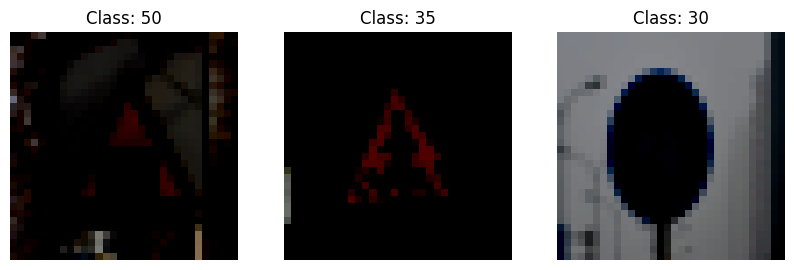

In [4]:
# CNN Implementation in pytorch 

import torch
import torch.nn as nn
import torch.nn.functional as F  
import torch.optim 
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


# transformation 
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

dataset = datasets.ImageFolder(root='/Users/ibhaankudalkar/Downloads/archive/traffic_Data/DATA', transform=transform)
num_classes = len(dataset.classes)
print(f"Number of classes: {num_classes}")

# train test split
train_size = int(0.7 * len(dataset)) # 70
val_size = int(0.15 * len(dataset)) # 15
test_size = len(dataset) - train_size - val_size # 15
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
print("Train size:", train_size)
print("Validation size:", val_size)
print("Test size:", test_size)
print(train_size + val_size + test_size)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Sample of images 
def samples(images, labels, class_names):
    plt.figure(figsize=(10, 4))
    for i in range(len(images)):  
        plt.subplot(1, len(images), i + 1)
        plt.imshow(images[i].permute(1, 2, 0).numpy())  
        plt.title(f"Class: {class_names[labels[i]]}")
        plt.axis('off')
    plt.show()

# batch of data
data_iter = iter(train_loader)
images, labels = next(data_iter)

# first 3 images
samples(images[:3], labels[:3], dataset.classes)

# print(f"Image shape: {sample_images[0].shape}")


Below I define the CNN Model class which inherits the pytorch module, making it structural and modular for training.
I define three convolutional layers:
The first layer processes the 3-channel RGB input with 32 filters of size 3x3.
The next two layers increase the number of filters to 64 and 128, capturing more complex patterns at each stage.
Padding of 1 ensures the output spatial dimensions remain consistent after convolution.
The max pooling layer is 2X2 to downsize the feature maps by half. Next, I flatten the maps to 128*4*4 for a dense mapping with 512 neurons.
Dropout layers are added to reduce overfitting by half.

In the Forward Pass, each layer is passed by a ReLu activation function compared to others as it outputs 0 for negative inputs and speeds the training in dense networks.
I have also added view for flattening it from 2D maps to 1D vector.
The CNN constructor adjusts the output layer to match the dataset’s classes, ensuring compatibility regardless of the number of categories.
The  Cross Entropy loss funtion helps to convert the c2 layer high probabilities to classes as it combines the log-softmax and negative log into a single log function.
Lastly, I have used Adam Optimizer as it reduces oscillation during gradient descent and gives a faster convergence rates with a learning rate of 0.001 for stability.

In [9]:
# CNN MODEL CLASS
class CNN(nn.Module):
    def __init__(self, number_classes):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.c1 = nn.Linear(128 * 4 * 4, 512)  
        self.dropout = nn.Dropout(0.5)
        self.c2 = nn.Linear(512, number_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 4 * 4) 
        x = F.relu(self.c1(x))
        self.dropout = nn.Dropout(0.5)
        x = self.c2(x)
        return x

# model intialization and optimization
model = CNN(number_classes=num_classes)
criteria = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In the Training Model, each epoch completes one round over training and validation.
The images and labels are put into batches as it optimizes the memory and are passed through the model to give prediction for each image.
the loss function tracks the difference in predictions and labels so I compute the gradient for the loss and the parameters are optimized.
The running loss is used to calculate the average training loss later on.
I specifically used zero_grad as my optimizer as it provides with each batch gradient computation and gradients from previous batches do not interfere with the current batch.

In the Validation step, I switch off the gradient descent with no_grad reducing memory usage. The validation dataset loaded in batches is passed through the model to generate predictions and for each batch the loss is calculated.
i did use torch.max to normalize the scores for each class.
Based on our predictions with the labels I calculate the accuracy.

Lastly, I print the metrics for each epoch and the call the training model.

Changing the epoch from 10 to 8 made validation accuracy stabilize at 98.40% after just the first epoch, showing that the model learns the key patterns quickly.
Training loss is extremely low, indicating that the model fits the training data almost perfectly.
the risk of overfitting is minimal with stable performance.


In [14]:
# train model for each epoch
def train_model(model, train_loader, val_loader,criteria, optimizer, epochs=8):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criteria(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        # Validation step
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                outputs = model(images)
                loss = criteria(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        
        print(f"Epoch {epoch+1}/{epochs}, "
              f"Train Loss: {running_loss/len(train_loader):.4f}, "
              f"Validation Loss: {val_loss/len(val_loader):.4f}, "
              f"Validation Accuracy: {100 * correct / total:.2f}%")

# Train the model
train_model(model, train_loader, val_loader, criteria, optimizer, epochs=8)


Epoch 1/8, Train Loss: 0.0026, Validation Loss: 0.1364, Validation Accuracy: 98.40%
Epoch 2/8, Train Loss: 0.0010, Validation Loss: 0.1459, Validation Accuracy: 98.40%
Epoch 3/8, Train Loss: 0.0003, Validation Loss: 0.1512, Validation Accuracy: 98.40%
Epoch 4/8, Train Loss: 0.0002, Validation Loss: 0.1544, Validation Accuracy: 98.40%
Epoch 5/8, Train Loss: 0.0002, Validation Loss: 0.1569, Validation Accuracy: 98.40%
Epoch 6/8, Train Loss: 0.0001, Validation Loss: 0.1588, Validation Accuracy: 98.40%
Epoch 7/8, Train Loss: 0.0001, Validation Loss: 0.1609, Validation Accuracy: 98.40%
Epoch 8/8, Train Loss: 0.0001, Validation Loss: 0.1625, Validation Accuracy: 98.40%


I seperately evaluate the trained model and set it to evaluation mode giving a accuracy score as a percentage for the model.
Lastly, I call the model on test_model.

An accuracy between 96-99% indicated the test samples are demonstrating good generalization to raw data.

In [19]:
# Testing and Evaluation
def test_model(model, test_loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f"Accuracy Score: {100 * correct / total:.2f}%")

test_model(model, test_loader)

Accuracy Score: 97.44%


Saving the model.

In [20]:
# save the model
torch.save(model, 'model.pth')
print('Saved trained model')

Saved trained model
